<a href="https://colab.research.google.com/github/JennEYoon/geo-ml/blob/main/rainforest/nbs-planet/JY_notes_gdrive_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/foo3.txt', 'w') as f:
  f.write('Hello MyDrive Colab Notebooks!')
!cat /content/drive/MyDrive/Colab\ Notebooks/foo3.txt

Hello MyDrive Colab Notebooks!

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


In [ ]:
# import fastai, fastbook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.9MB/s 
     |████████████████████████████████| 1.2MB 37.5MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 204kB 49.8MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
Mounted at /content/gdrive


In [ ]:
!ls

drive  gdrive  sample_data


In [ ]:
from pathlib import Path

In [ ]:
path_tr = Path('/content/gdrive/MyDrive/repos/data-big/planet-jpg/train-jpg/')
path_tr

Path('/content/gdrive/MyDrive/repos/data-big/planet-jpg/train-jpg')

In [ ]:
# Read in sample image file
fn = 'train_5.jpg'
q = path_tr / fn
print(q)
q.exists()


/content/gdrive/MyDrive/repos/data-big/planet-jpg/train-jpg/train_5.jpg


True

In [ ]:
from PIL import Image
im = Image.open(q)
#im
print(im.mode)

CMYK


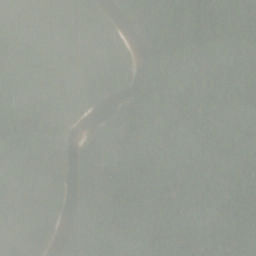

In [ ]:
if im.mode == 'CMYK': 
    rgb_image = im.convert('RGB')
    
rgb_image

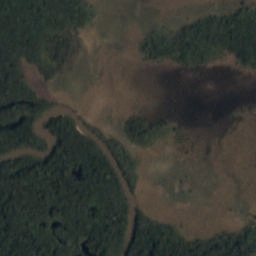

In [ ]:
# Read another image
fn = 'train_10.jpg'
q = path_tr / fn

im2 = Image.open(q)
if im2.mode == 'CMYK': 
    rgb_image2 = im2.convert('RGB')
    
rgb_image2

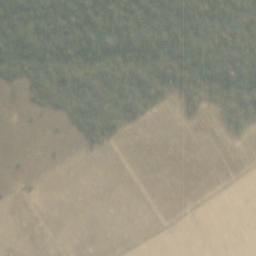

In [ ]:
# Read another image
fn = 'train_9.jpg'
q = path_tr / fn

im3 = Image.open(q)
if im3.mode == 'CMYK': 
    rgb_image3 = im3.convert('RGB')
    
rgb_image3

In [ ]:
# Read labels, train_v2.csv  
import pandas as pd

In [ ]:
path = Path('/content/gdrive/MyDrive/repos/data-big/planet-jpg')
df = pd.read_csv(path/'train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
len(df)

40479

In [ ]:
df['tags'].str.len().max()
# df.col1.str.len().max()

92

In [ ]:
# Stopped here.  
# Load into fastai v2 pkg: datasets, data loader. 


#$ Chp 19: fastai Learner from Scratch    

Chp 19 has datasets, datablocks, dataloaders detail

### Data - Imagenette 160
Have a look at the source to untar_data to see how it works. We'll use it here to access the 160-pixel version of Imagenette for use in this chapter:

In [ ]:
# Mount google drive with path to data files.  
# Run cells to load fastai, fastbook, setup()
'''
# import fastai, fastbook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
'''
# Define path, URLs is fastai aws s3 bucket.  Imagenette_160 is lower resolution files.
path = untar_data(URLs.IMAGENETTE_160)

t = get_image_files(path)
t[0]  
# Path('/home/jhoward/.fastai/data/imagenette2-160/val/n03417042/n03417042_3752.JPEG') on local linux server. 
# Will point to image path on mounted google drive instead.  

In [ ]:
# Indexing into image files in folder, using Python glob built-in. 
from glob import glob
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

In [ ]:
# If you look at the source for get_image_files, you'll see it uses Python's os.walk; 
# this is a faster and more flexible function than glob, so be sure to try it out. 


In [ ]:
# We can open an image with the Python Imaging Library's Image class
im = Image.open(files[0])
im  
# output image of truck

In [ ]:
# Shape
im_t = tensor(im)
im_t.shape
# output: torch.Size([160, 213, 3])  
# That's going to be the basis of our independent variable. 

In [ ]:
# For our dependent variable, we can use Path.parent from pathlib. 
# First we'll need our vocab 
lbls = files.map(Self.parent.name()).unique(); 
lbls

In [ ]:
# ...and the reverse mapping, thanks to L.val2idx 
v2i = lbls.val2idx(); 
v2i

### Dataset

A Dataset in PyTorch can be anything that supports indexing (__getitem__) and len. 

In [ ]:
class Dataset:
    def __init__(self, fns): self.fns=fns
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float()/255, tensor(y)

In [ ]:
# We need a list of training and validation filenames to pass to Dataset.__init__() 
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)
# (9469, 3925)

In [ ]:
# try
train_ds,valid_ds = Dataset(train),Dataset(valid)
x,y = train_ds[0]
x.shape,y
# (torch.Size([64, 64, 3]), tensor(0))

In [ ]:

show_image(x, title=lbls[y]);
# image of truck with filename label on top
# 
# As you see, our dataset is returning the independent and dependent variables 
# as a tuple, which is just what we need. We'll need to be able to collate these 
# into a mini-batch. Generally this is done with torch.stack, which is what we'll use here:

In [ ]:

def collate(idxs, ds): 
    xb,yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb),torch.stack(yb)

In [ ]:
# Collated
# Here's a mini-batch with two items, for testing our collate
x,y = collate([1,2], train_ds)
x.shape,y
# output:  (torch.Size([2, 64, 64, 3]), tensor([0, 0]))

### Data Loader  
Now that we have a dataset and a collation function, we're ready to create DataLoader. We'll add two more things here: an optional shuffle for the training set, and a ProcessPoolExecutor to do our preprocessing in parallel. A parallel data loader is very important, because opening and decoding a JPEG image is a slow process. One CPU core is not enough to decode images fast enough to keep a modern GPU busy. Here's our DataLoader class:

In [ ]:

class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)

In [ ]:
# Let's try it out with our training and validation datasets: 
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)
# output:  (torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)  

This data loader is not much slower than PyTorch's, but it's far simpler. So if you're debugging a complex data loading process, don't be afraid to try doing things manually to help you see exactly what's going on.